In [1]:
import torch
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00


In [2]:
!pip install matplotlib
%matplotlib inline
!pip install matplotlib-inline
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
%matplotlib inline
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision import datasets, transforms
import torch.optim as optim
from d2l import torch as d2l
from torch.optim import lr_scheduler

In [4]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Resize((64,64)),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64,64)),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Files already downloaded and verified


In [6]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [7]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.01, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(1000), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [8]:
net = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)), lr=0.01)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
net

VGG(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [10]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:

from torchinfo import summary

model = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
batch_size = 16
summary(model, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Sequential: 2-1                   [16, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [16, 64, 64, 64]          1,792
│    │    └─BatchNorm2d: 3-2             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [16, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [16, 64, 64, 64]          36,928
│    │    └─BatchNorm2d: 3-5             [16, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [16, 64, 64, 64]          --
│    │    └─MaxPool2d: 3-7               [16, 64, 32, 32]          --
│    └─Sequential: 2-2                   [16, 128, 16, 16]         --
│    │    └─Conv2d: 3-8                  [16, 128, 32, 32]         73,856
│    │    └─BatchNorm2d: 3-9             [16, 128, 32, 32]         256
│

In [12]:
def train(model, train_loader, test_loader, num_epochs, loss_fn, trainer):
            
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train accuracy', 'test accuracy'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  
        for i, (imags, labels) in enumerate(train_loader):
            net.train()
            trainer.zero_grad()
            labels_hat = net(imags)
            l = loss_fn(labels_hat, labels)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * imags.shape[0], d2l.accuracy(labels_hat, labels), imags.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_loader),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(model, test_loader)
        animator.add(epoch+1, (None, None, test_acc))

    print(f'train loss {train_loss:.3f}, train accuracy {train_acc:.3f}, 'f'test accuracy {test_acc:.3f}')

In [13]:
loss = nn.CrossEntropyLoss()
batch_size = 16
num_epochs = 5
lr=0.01

In [14]:
train_loader= torch.utils.data.DataLoader(batch_size=batch_size, dataset = cifar_trainset)
net= VGG(num_classes=10, arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [15]:
test_loader= torch.utils.data.DataLoader(batch_size=batch_size, dataset = cifar_testset)

train loss 0.352, train accuracy 0.881, test accuracy 0.802


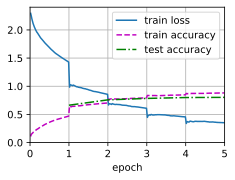

In [16]:
train(net, train_loader, test_loader, num_epochs, loss, trainer)